## Exploring Malaria Simulation Output Data

In [22]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# Some base data
strategies = ['AL5',
              'AL4',
              'AL25-ASAQ75',
              'AL25-DHAPPQ75',
              'AL50-ASAQ50',
              'AL50-DHAPPQ50',
              'AL75-ASAQ25',
              'AL75-DHAPPQ25',
              'ASAQ',
              'ASAQ25-DHAPPQ75',
              'ASAQ50-DHAPPQ50',
              'ASAQ75-DHAPPQ25',
              'DHA-PPQ',
              'status_quo'
              ]

table_names = ['monthlydata', 'sqlite_sequence', 'monthlysitedata', 'genotype', 'monthlygenomedata']

# Database tools -----------------------------------------------------------------------------
def get_all_tables(db: str) -> list:
    """
    Get all tables in a sqlite3 database

    Args:
    db (str): path to sqlite3 database

    Returns:
    list: list of tables in the database
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        c = conn.cursor()
        c.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = c.fetchall()
    
    return [table[0] for table in tables]

def get_table(db: str, table: str) -> pd.DataFrame:
    """
    Get a table from a sqlite3 database

    Args:
    db (str): path to sqlite3 database
    table (str): name of table to get

    Returns:
    pd.DataFrame: table as a pandas DataFrame
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    
    return df

# Data analysis tools -----------------------------------------------------------------------
def calculate_treatment_failure_rate(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate treatment failures for a given table

    Args:
    data (DataFrame): monthlysitedata table to calculate treatment failures

    Returns:
    pd.DataFrame: table with treatment failures
    """
    # Calculate treatment failures
    data['failure_rate'] = data['treatmentfailures'] / data['treatments']
    return data

#def aggregate_monthlysitedata(path: str, strategy: str, locationid: int = 0) -> pd.DataFrame:
def aggregate_failure_rates(path: str, strategy: str, locationid: int = 0) -> pd.DataFrame:
    """
    Aggregate failure rate data by strategy. This function searchs path for all the result 
    files for the given strategy and aggregates them.

    Args:
    path (str): path to search for result files
    strategy (str): strategy to aggregate data for
    locationid (int): locationid to filter by, defaults to 0 which returns all locations

    Returns:
    pd.DataFrame: aggregated data
    pd.Series: monthlydataid column
    """
    # Get all files for the strategy
    files = glob.glob(os.path.join(f"{path}", f"{strategy}_*.db"))
    if len(files) == 0:
        print(f"No files found for strategy {strategy} in {path}")
        return
    else:
        print(f"Aggregating data for strategy {strategy} with {len(files)} files")
    summary = pd.DataFrame()
    for file in files:
        data = get_table(file, 'monthlysitedata')
        data = calculate_treatment_failure_rate(data)
        if locationid > 0:
            data = data[data["locationid"] == locationid]
        months = data['monthlydataid'].unique()
        locations = data['locationid'].unique()
        data_summary = pd.DataFrame(index=months, columns=locations)
        for location in locations:
            location = int(location)
            failures = data.loc[data['locationid'] == location, ['monthlydataid', 'failure_rate']]
            failures.index = failures['monthlydataid']
            data_summary[location] = failures['failure_rate']
        if locationid > 0:
            summary[file] = data_summary.sum(axis=1)
        else:
            summary[file] = data_summary.mean(axis=1)
    summary['mean'] = summary.mean(axis=1)
    summary['median'] = summary.median(axis=1)
    summary['95th'] = summary.quantile(axis=1, q=0.95)
    summary['5th'] = summary.quantile(axis=1, q=0.05)
    return summary

def save_aggregated_data(monthlysitedata: dict[str, pd.DataFrame], monthlydataid: pd.Series, strategy: str, path: str):
    """
    Save aggregated data to a file

    Args:
    monthlysitedata (dict[str, pd.DataFrame]): aggregated data
    monthlydataid (pd.Series): monthlydataid column
    strategy (str): strategy
    path (str): path to save the file
    """
    with sqlite3.connect(os.path.join(path, f"{strategy}_aggregated.db")) as conn:
        for column in monthlysitedata.keys():
            monthlysitedata[column].to_sql(column, conn, index=False)
        monthlydataid.to_sql('monthlydataid', conn, index=False)

def plot_strategy_treatment_failure(data: pd.DataFrame, strategy: str, figsize: tuple = (18, 3)):
    """
    Plot treatment failure rate for a given strategy

    Args:
        data (pd.DataFrame): treatement failure data to plot from aggregate_failure_rates
        months (pd.DataFrame): months for the data
        strategy (str): strategy to plot
        figsize (tuple): figure size
    
    Returns:    
        tuple: figure and axis
    """
    fig, ax = plt.subplots(figsize=figsize)
    #ax.plot(months / 12, data['failure_rate']['mean'], label='Mean')
    ax.plot(data.index / 12, data['median'], label='Median')
    ax.fill_between(data['median'].index / 12, 
                    data['5th'], 
                    data['95th'], color='b', alpha=0.15, label='5th-95th percentile')
    ax.axhline(y=0.1, color='r', linestyle='--', label='10% threshold')
    ax.set_title(f"{strategy} Treatment Failure Rate")
    ax.set_xlabel("Years")
    ax.set_ylabel("Treatment Failure Rate")
    ax.legend()
    return fig, ax

def get_population_data(file: str, month: int = -1) -> pd.DataFrame:
    """
    Get the population data for a given file and month

    Args:
    file (str): path to sqlite3 database
    month (int): month to filter by, defaults to -1 which returns the last month

    Returns:
    pd.DataFrame: population data
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    population_data = get_table(file, 'monthlysitedata')
    if month > 0:
        population_data = population_data.loc[population_data['monthlydataid'] == month]
    else:
        last_month = population_data.iloc[-1]['monthlydataid']
        population_data = population_data.loc[population_data['monthlydataid'] == last_month]
    population_data = population_data[['locationid', 'population', 'infectedindividuals']]
    population_data.index = population_data['locationid']
    population_data = population_data.drop(columns='locationid')
    return population_data

def get_genome_data(file: str, month: int = -1) -> pd.DataFrame:
    """
    Get the genome data for a given file and month

    Args:
    file (str): path to sqlite3 database
    month (int): month to filter by, defaults to -1 which returns the last month

    Returns:
    pd.DataFrame: genome data
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    genome_data = get_table(file, 'monthlygenomedata')
    if len(genome_data) == 0:
        raise ValueError(f"No genome data found in {file}")    
    if month > 0:
        genome_data = genome_data.loc[genome_data['monthlydataid'] == month]
    else:
        last_month = genome_data.iloc[-1]['monthlydataid']
        genome_data = genome_data.loc[genome_data['monthlydataid'] == last_month]
    genome_data = genome_data[['locationid', 'genomeid', 'occurrences', 'weightedoccurrences']]
    genome_data.index = genome_data['locationid']
    genome_data = genome_data.drop(columns='locationid')
    return genome_data

def calculate_genome_frequencies(file: str, month: int = -1) -> pd.DataFrame:
    """
    Calculate the genome frequencies

    Args:
    file (str): path to sqlite3 database
    month (int): month to filter by, defaults to -1 which returns the last month

    Returns:
    pd.DataFrame: genome frequency data
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    # Get the genomes
    genomes = get_table(file, 'genotype')
    # Get the genome data
    genome_data = get_genome_data(file, month)
    # Get the population data
    population_data = get_population_data(file, month)
    # Calculate the genome frequencies
    genome_frequencies = pd.DataFrame(index=population_data.index, columns=genomes['id'].to_list())
    totals = []
    for genome in genomes['id'].to_list():
        occurrences = genome_data.loc[genome_data['genomeid'] == genome, ['occurrences']]
        occurrences = occurrences.join(population_data, how='outer').fillna(0)
        genome_frequencies[genome] = occurrences['occurrences'] / occurrences['population']
        totals.append(occurrences['occurrences'].sum() / occurrences['population'].sum())
    genome_frequencies.loc['totals'] = totals
    return genome_frequencies

def get_resistant_genotypes(genomes: pd.DataFrame, allele: str) -> pd.DataFrame:
    """
    Get the genotypes that are resistant to an arbitrary drug by selecting
    genotypes that contain the allele that confers resistance.

    Args:
    genomes (pd.DataFrame): genotype data
    allele (str): allele to filter by

    Returns:
    pd.DataFrame: resistant genotypes
    """
    resistant_genotypes = genomes.loc[genomes['name'].str.contains(allele)]
    return resistant_genotypes

def calculate_resistant_genome_frequencies(file: str, allele: str, month: int = -1, locationid: int = -1) -> float:
    """
    Calculate the frequency or prevelance of drug resistant genotypes based on the presence of an allele that confers resistance.

    Args:
    file (str): path to sqlite3 database
    allele (str): allele to filter by, defaults to 'H'
    month (int): month to filter by, defaults to -1 which returns the last month
    locationid (int): locationid to filter by, defaults to -1 which returns all locations
    
    Returns:
    float: resistant genome prevelance
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    genomes = get_table(file, 'genotype')
    resistant_genotypes = genomes.loc[genomes['name'].str.contains(allele)]
    pop = get_table(file, 'monthlysitedata')
    parasite = get_table(file, 'monthlygenomedata')
    fqy = pop[['monthlydataid', 'locationid', 'population', 'infectedindividuals']].merge(parasite[['monthlydataid', 'locationid', 'genomeid', 'occurrences', 'weightedoccurrences']], on=['monthlydataid','locationid']).fillna(0)
    fqy['frequency'] = fqy['weightedoccurrences'] / fqy['infectedindividuals']
    # resistant_genome_data = genome_data[genome_data['genomeid'].isin(resistant_genotypes['id'])]
    fqy = fqy[fqy['genomeid'].isin(resistant_genotypes['id'])]
    if locationid > 0:
        fqy = fqy[fqy['locationid'] == locationid]
    if month > 0:
        fqy = fqy[fqy['monthlydataid'] == month]
    else:
        fqy = fqy[fqy['monthlydataid'] == fqy['monthlydataid'].max()]
    return fqy

def aggregate_resistant_genome_frequencies(path: str, strategy: str, allele: str = 'H', month: int = -1, locationid: int = -1) -> pd.DataFrame:
    """
    Aggregate genome frequencies for a given strategy

    Args:
    path (str): path to search for result files
    strategy (str): strategy to aggregate data for
    locationid (int): locationid to filter by

    Returns:
    pd.DataFrame: aggregated genome frequencies
    """
    # Get all files for the strategy
    files = glob.glob(os.path.join(f"{path}", f"{strategy}_*.db"))
    if len(files) == 0:
        print(f"No files found for strategy {strategy} in {path}")
        return
    else:
        print(f"Aggregating data for strategy {strategy} with {len(files)} files")
    # Get the monthlysitedata table for the first file to set up aggregated data
    genome_frequencies = [] #pd.DataFrame() 
    # Aggregate data for the rest of the files
    for file in files:
        print(f"Aggregating data for {file}")
        #data = calculate_genome_frequencies(file)
        try:
            fqy = calculate_resistant_genome_frequencies(file, allele, month, locationid)
        except TypeError as e:
            print(e)
            continue
        except FileNotFoundError as e:
            print(e)
            continue
        except IndexError as e:
            print(e)
            print(f"Length of data: {len(genome_frequencies)}")
            continue
        except ValueError as e:
            print(e)
            continue
        if len(fqy) > 0:
            #genome_frequencies.append(fqy)
            if locationid > 0:
                genome_frequencies.append(fqy['frequency'].sum())
            else:
                genome_frequencies.append(fqy)
        
    return genome_frequencies

def plot_strategy_results(path: str, strategy: str, locationid:int = 0) -> plt.Figure:
    """
    Plots the treatment failure rate for a given strategy. If locationid is provided, only that location is plotted.
    If more than one results file is found in the path, the data is aggregated.

    Args:
    path (str): path to directory containing results files
    strategy (str): strategy to plot
    locationid (int): locationid to filter by

    Returns:
    plt.Figure: matplotlib figure
    """
    # Assert that the location is valid
    if locationid < 0:
        raise ValueError("locationid must be a positive integer")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    # Get all results files in the path
    results_files = glob.glob(os.path.join(path, f"{strategy}_.db"))
    if len(results_files) == 0:
        raise FileNotFoundError(f"No results files found for strategy {strategy}")
    # Read all results files
    failures = pd.DataFrame()
    for file in results_files:
        data = get_table(file, 'monthlysitedata')
        data = calculate_treatment_failure_rate(data, locationid)
        failures[file] = data['failure_rate']
        
    if locationid > 0:
        failures = failures.loc[failures['locationid'] == locationid]
    # else, aggregate all locations by taking the mean of the failure rates at each month
    else:
        months = failures['monthlydataid'].unique()
        monthly_average = pd.DataFrame()
        for month in months:
            monthly_data = failures.loc[failures['monthlydataid'] == month]
            monthly_average[month, 'population'] = monthly_data['population'].sum()
            monthly_average[month, 'treatments'] = monthly_data['treatments'].sum()
            monthly_average[month, 'treatmentfailures'] = monthly_data['treatmentfailures'].sum()
            monthly_average[month, 'failure_rate'] = monthly_data['failure_rate'].mean()

    failures['mean'] = failures.mean(axis=1)
    fig, ax = plt.subplots()
    ax.plot(failures['monthlydataid'])

In [10]:
#DATA_ROOT: str = os.path.join("G:\\", "My Drive")
DATA_ROOT: str = os.path.join("/", "home", "james", "Code", "Temple-Malaria-Simulation-Analysis")
#DATA_SOURCE: str = os.path.join(DATA_ROOT, "Code", "output_old")
DATA_SOURCE: str = os.path.join(DATA_ROOT, "output", "rwa")
filelist = glob.glob(os.path.join(DATA_SOURCE, "*.db"))

In [ ]:
# Create treatment failure plots for all strategies
# Note: due to incomplete batch runs, some strategies may not have data or have incomplete data
# Incomplete data will result in a ValueError when plotting due to a dimension mismatch
for strategy in strategies:
    try:
        data = aggregate_failure_rates(DATA_SOURCE, strategy)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    if data is None:
        print(f"No data found for {strategy} or there was an aggregation error")
        continue
    try:
        fig, ax = plot_strategy_treatment_failure(data, strategy.replace("_", " ").title())
    except ValueError as e:1
        print(e)
        plt.close(fig)
        continue
    plt.savefig(f"{strategy}.png")
    plt.close(fig)

Aggregating data for strategy AL5 with 50 files
Aggregating data for strategy AL4 with 50 files
Aggregating data for strategy AL25-ASAQ75 with 50 files
Aggregating data for strategy AL25-DHAPPQ75 with 50 files
Aggregating data for strategy AL50-ASAQ50 with 50 files
Aggregating data for strategy AL50-DHAPPQ50 with 50 files
Aggregating data for strategy AL75-ASAQ25 with 50 files
Aggregating data for strategy AL75-DHAPPQ25 with 50 files
Aggregating data for strategy ASAQ with 50 files
Aggregating data for strategy ASAQ25-DHAPPQ75 with 50 files
Aggregating data for strategy ASAQ50-DHAPPQ50 with 50 files
Aggregating data for strategy ASAQ75-DHAPPQ25 with 50 files
Aggregating data for strategy DHA-PPQ with 50 files
Aggregating data for strategy status_quo with 50 files


In [23]:
fqy_1 = aggregate_resistant_genome_frequencies(DATA_SOURCE, 'status_quo', 'H', 385, 1)
fqy_all = aggregate_resistant_genome_frequencies(DATA_SOURCE, 'status_quo', 'H', 385)

Aggregating data for strategy status_quo with 50 files
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/status_quo_8_run_8_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/status_quo_29_run_29_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/status_quo_46_run_46_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/status_quo_7_run_7_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/status_quo_9_run_9_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/status_quo_26_run_26_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/status_quo_14_run_14_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/status

In [24]:
fqy_1

[np.float64(0.9855754796801225),
 np.float64(0.9921949954622066),
 np.float64(0.9981712255401415),
 np.float64(0.9813050570962483),
 np.float64(0.9782629690949227),
 np.float64(0.9801726243791217),
 np.float64(0.9863591473952762),
 np.float64(0.9971247921946967),
 np.float64(0.99850774109308),
 np.float64(0.9880431848852903),
 np.float64(0.9903026601520085),
 np.float64(1.0000000000000004),
 np.float64(0.9964020992263161),
 np.float64(0.996312148375461),
 np.float64(0.9828801204981307)]

Aggregating data for strategy AL5 with 50 files
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/AL5_25_run_25_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/AL5_39_run_39_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/AL5_15_run_15_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/AL5_38_run_38_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/AL5_26_run_26_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/AL5_44_run_44_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/AL5_22_run_22_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/output/rwa/AL5_29_run_29_monthly_data_0.db
Aggregating data for /ho

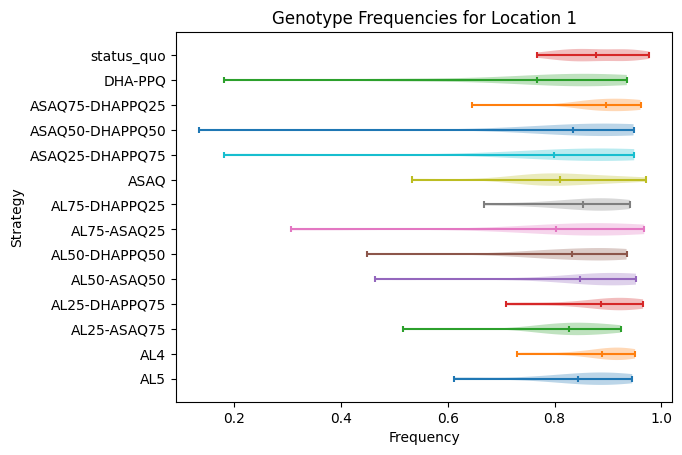

In [28]:
# Create a violin plot for a given genotype based on the row in agg_fqy
fig, ax = plt.subplots()
locationid = 1
for i, strategy in enumerate(strategies):
    try:
        agg_fqy = aggregate_resistant_genome_frequencies(DATA_SOURCE, strategy, 'H', 325, locationid)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    except ValueError as e:
        print(e)
        continue
    except IndexError as e:
        print(e)
        continue
    try:
        ax.violinplot(agg_fqy, positions=[i], showmeans=True, orientation='horizontal')
    except Exception as e:
        print(e)
        print(f"Error plotting {strategy}")
        continue
title = f"Genotype Frequencies"# for Location {locationid}"
if locationid > 0:
    title += f" for Location {locationid}"
ax.set_title(title)
ax.set_xlabel("Frequency")
ax.set_ylabel("Strategy")
ax.set_yticks(range(len(strategies)))
ax.set_yticklabels(strategies)
plt.savefig("genotype_frequencies_violins.png")
plt.show()

In [ ]:
pop = get_table(filelist[0], 'monthlysitedata')
parasite = get_table(filelist[0], 'monthlygenomedata')
genomes = get_table(filelist[0], 'genotype')

In [ ]:
P = pop[['monthlydataid', 'locationid', 'population', 'infectedindividuals']]
G = parasite[['monthlydataid', 'locationid', 'genomeid', 'occurrences', 'weightedoccurrences']]
fqy = P.merge(G, on=['monthlydataid','locationid']).fillna(0)
fqy['frequency'] = fqy['weightedoccurrences'] / fqy['infectedindividuals']
res = genomes.loc[genomes['name'].str.contains('H')]

In [ ]:
fqy = calculate_resistant_genome_frequencies(filelist[0], 'H')

In [ ]:
fqy['frequency'].sum() / 30

In [ ]:
len(fqy['locationid'].unique())

In [ ]:

w = fqy['weightedoccurrences'].sum()
i = fqy.iloc[0]['infectedindividuals']
p = fqy.iloc[0]['population']
f = fqy['frequency'].sum()

In [ ]:
import numpy as np
W = np.empty(len(fqy['locationid'].unique()))
I = np.empty(len(fqy['locationid'].unique()))
P = np.empty(len(fqy['locationid'].unique()))
F = np.empty(len(fqy['locationid'].unique()))

for loc in fqy['locationid'].unique():
    fqy_loc = fqy.loc[fqy['locationid'] == loc]
    W[loc-1] = fqy_loc['weightedoccurrences'].sum()
    I[loc-1] = fqy_loc.iloc[0]['infectedindividuals']
    P[loc-1] = fqy_loc.iloc[0]['population']
    F[loc-1] = fqy_loc['frequency'].sum()

In [ ]:
W.sum() / I.sum() # Do this one

In [ ]:
F.mean()

In [ ]:
F.sum() / 30

In [27]:
385 - 12*5

325

In [29]:
import math

In [30]:
math.ceil(2.98)

3

In [33]:
32 * 8 / 128

2.0

In [34]:
128 / 8

16.0